W ostatecznym milestonie zajmiemy się wykrestalizowaniem najefektywniejszych modeli i zestawieniem ich w zwięzłej analizie. Dokonaliśmy poprawek zaproponowanych przez prowadzącego względem poprzedniego kamienia milowego i ostatecznie zamkneliśmy naszą pracę. Zaprezentowane modele będą znacznie bardziej zaawansowane niż ich uprzednie wersje z poprzedniego punktu kontrolnego.

## Import danych oraz bibliotek
Zacznijmy od importu wymaganych bibliotek oraz załadowania naszej nieobrobionej ramki danych. 

In [ ]:
import pandas as pd
from numpy import array
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import poisson,expon
from itertools import permutations

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

In [ ]:
raw_df = pd.read_csv("https://lovespreadsheet-tutorials.s3.amazonaws.com/APIDatasets/congressional_voting_dataset.csv")

## Zwięzły preprocessing
Przed kontynuacją naszą "surową" ramkę należy poddać obróbce, tak jak we wcześniejszym milestonie.

In [ ]:
df = raw_df.copy()

# kodowanie tak, żeby zachować stopniowanie głosów (n < ? < y)
vote_encoder = OrdinalEncoder([["n", "?", "y"]]*16) # n -> 0, ? -> 1, y -> 2
df.iloc[:, :-1] = vote_encoder.fit_transform(df.iloc[:, :-1]) 

party_encoder = LabelEncoder()
party_encoder.fit(["republican", "democrat"]) # republican -> 1, democrat -> 0
df.iloc[:, -1] = party_encoder.transform(df.iloc[:, -1])

df = df.convert_dtypes()

In [ ]:
# podział na feature, label
X = df.iloc[:, :-1]
y = df.iloc[:, -1].astype("int")

## Zdefiniowane funkcje
Przy naszej analizie użyliśmy wcześniej zdefiniowanych funkcji by uzwięźić nasz kod/raport, zatem zaprezentujmy je przy początku dokumentu.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=33, stratify=y) # <---------- stratify

In [ ]:
print(pd.DataFrame(y_train).value_counts())
print(pd.DataFrame(y_test).value_counts())

political_party
0                  160
1                  101
dtype: int64
political_party
0                  107
1                   67
dtype: int64


Tym razem wykorzystaliśmy opcję stratify przy tworzeniu zbiorów treningowego oraz testowego, gdyż przypominając checę naszej ramki, jest ona niezbalansowana pod względem wyników (demokratów jest około dwa razy więcej).

In [ ]:
# Parametryzacja funkcji na zbiory danych
def plot_scores(model, sets=(X_train, X_test, y_train, y_test)):
  X_train_, X_test_, y_train_, y_test_ = sets  # rozpakowywanie, dla modeli działających na podzbiorach cech

  fig, axs = plt.subplots(2, 2)
  plot_confusion_matrix(
      model, X_train_, y_train_,
      display_labels=party_encoder.classes_,
      values_format="d",
      ax=axs[0, 0]
  )
  axs[0, 0].set_title("Train data confusion matrix")

  plot_confusion_matrix(
      model, X_test_, y_test_,
      display_labels=party_encoder.classes_,
      values_format="d",
      ax=axs[0, 1]
  )
  axs[0, 1].set_title("Test data confusion matrix")

  plot_roc_curve(model, X_test_, y_test_, ax=axs[1, 0])
  axs[1,0].set_title("ROC curve")

  plot_precision_recall_curve(model, X_test_, y_test_, ax=axs[1, 1])
  axs[1, 1].set_title("Precision recall curve")
  axs[1, 1].set_ylim(0, 1)
  
  fig.set_size_inches(15, 15)
  fig.show()

def print_metrics(model, sets=(X_train, X_test, y_train, y_test)):
  X_train_, X_test_, y_train_, y_test_ = sets

  y_train_pred, y_test_pred = model.predict(X_train_), model.predict(X_test_)

  from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

  print(f"Accuracy score (train): {accuracy_score(y_train_, y_train_pred):.3f}")
  print(f"Accuracy score (test): {accuracy_score(y_test_, y_test_pred):.3f}")

  print(f"F1 score (train): {accuracy_score(y_train_, y_train_pred):.3f}")
  print(f"F1 score (test): {accuracy_score(y_test_, y_test_pred):.3f}")

  try:
    y_train_proba, y_test_proba = model.predict_proba(X_train_)[:, 1], model.predict_proba(X_test_)[:, 1]
    print(f"ROC AUC score (train): {roc_auc_score(y_train_, y_train_proba):.3f}")
    print(f"ROC AUC score (test): {roc_auc_score(y_test_, y_test_proba):.3f}")
  except Exception:
    print("No predict_proba(), can't compute ROC AUC score \n")

  try:
    print(f"Tree depth: {model.get_depth()}")
    print(f"Leaf count: {model.get_n_leaves()}")
  except Exception:
    pass

def results_tuned(model, n=5, head=True):
  results = pd.DataFrame(model.cv_results_)
  results.sort_values(by = 'rank_test_score', inplace = True)
  results = results[list(map(lambda x: "param_" + x, model.param_grid.keys())) + ['mean_test_score', 'std_test_score', 'rank_test_score']]
  if head:
    return results.head(n)
  else:
    return results.tail(n)

## Tuning drzewa decyzyjnego
Przy trenowaniu drzew decyzyjnych znaleźliśmy, że model o głębokości 3 jest najbardziej obiecujący, ale być może coś przeoczyliśmy. Zastosowaliśmy zatem przeszukiwanie po siatce hiperparametrów oraz kroswalidację, aby sprawdzić czy nasze drzewo decyzyjne faktycznie jest jednym z lepszych.

In [ ]:
kf5 = KFold(n_splits=5, shuffle=True, random_state=420)

tree_tune_pgrid = {
  'max_depth' : [i for i in range(1, 9)],
  'min_samples_split' : [1, 2] + [i for i in range(4, 33, 4)],
  'splitter': ["best", "random"],
  'min_impurity_decrease': [i/100 for i in range(11)] 
}

In [ ]:
tree_tune = GridSearchCV(
    estimator= DecisionTreeClassifier(random_state=420), 
    param_grid=tree_tune_pgrid, 
    cv = kf5,
    return_train_score = False,
    n_jobs=-1
)
tree_tune.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=420, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=420,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_g

In [ ]:
print_metrics(tree_tune.best_estimator_)

results_tuned(tree_tune)

Accuracy score (train): 0.977
Accuracy score (test): 0.937
F1 score (train): 0.977
F1 score (test): 0.937
ROC AUC score (train): 0.994
ROC AUC score (test): 0.973
Tree depth: 3
Leaf count: 7


,param_max_depth,param_min_samples_split,param_splitter,param_min_impurity_decrease,mean_test_score,std_test_score,rank_test_score
1129,6,12,random,0.01,0.965457,0.018902,1
1349,7,12,random,0.01,0.965457,0.018902,1
463,3,2,random,0.01,0.965457,0.018902,1
1345,7,4,random,0.01,0.965457,0.018902,1
1343,7,2,random,0.01,0.965457,0.018902,1


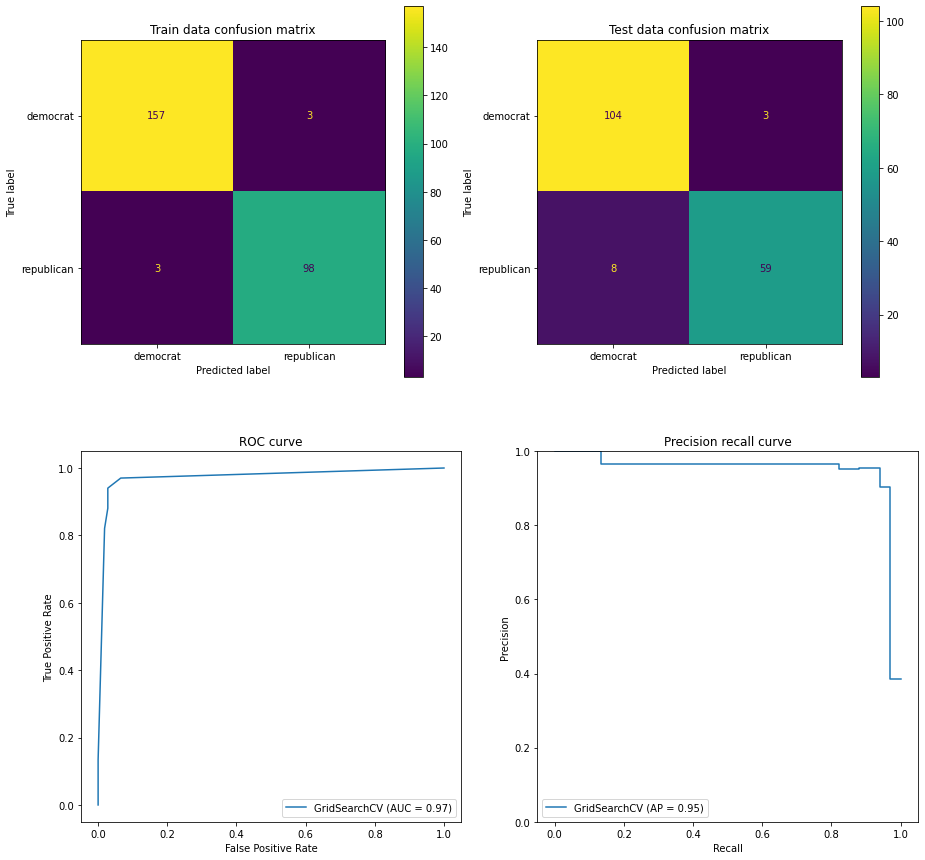

In [ ]:
plot_scores(tree_tune)

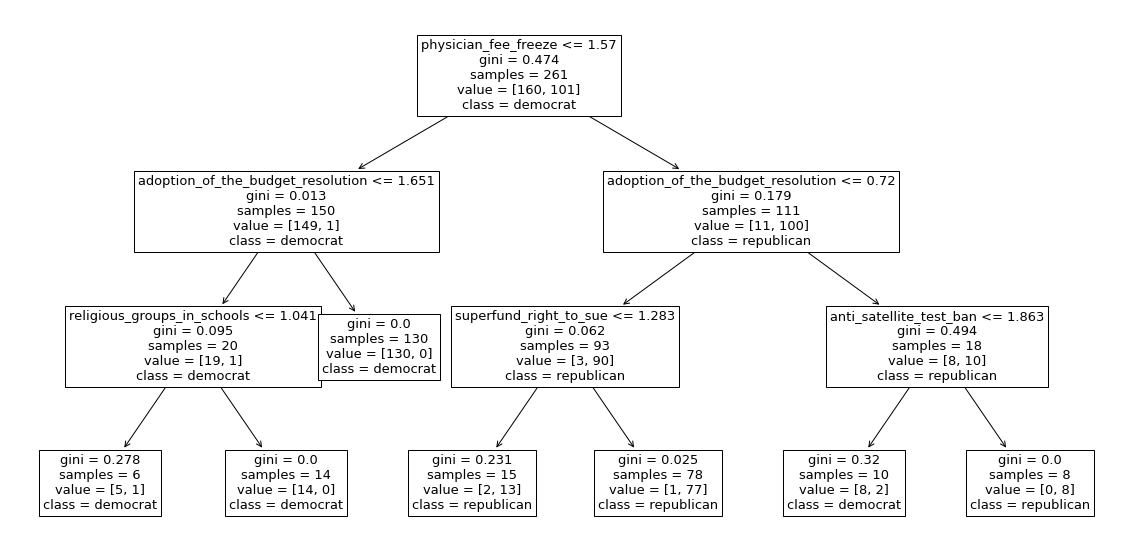

In [ ]:
def plot_model(model):
  plt.figure(figsize=(20, 10))
  plot_tree(model, feature_names=df.iloc[:, :-1].columns, class_names=party_encoder.classes_,fontsize=13)
  plt.show()
plot_model(tree_tune.best_estimator_)

In [ ]:
tree_tune.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=420, splitter='random')

## Alternatywny preprocessing
Podczas naszego preprocessingu korzystaliśmy z zależności `n < ? < y`, ale pytanie czy pomogliśmy modelom wprowadzając taką zależność? Wytrenujemy model na danych przygotowanych za pomocą One Hot Encoding i porównamy do drzewa decyzyjnego.

In [ ]:
alt_df = raw_df.copy()

# podział na feature, label
aX = alt_df.iloc[:, :-1]
ay = alt_df.iloc[:, -1]

# OHE na ustawy
cols = aX.columns
ohe = OneHotEncoder()
ohe.fit(aX)
aX = ohe.transform(aX)
# pd.DataFrame(ohe.inverse_transform(aX), columns=cols)

# label_enc taki sam
party_encoder = LabelEncoder()
party_encoder.fit(["republican", "democrat"]) # republican -> 1, democrat -> 0
ay = party_encoder.transform(ay)

In [ ]:
aX_train, aX_test, ay_train, ay_test = train_test_split(aX, ay, test_size=0.4, random_state=33, stratify=ay)

In [ ]:
alt_tree_tune = GridSearchCV(
    estimator= DecisionTreeClassifier(random_state=420), 
    param_grid=tree_tune_pgrid, 
    cv = kf5,
    return_train_score = False,
    n_jobs=-1
)
alt_tree_tune.fit(aX_train, ay_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=420, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=420,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_g

In [ ]:
print_metrics(alt_tree_tune, sets=(aX_train, aX_test, ay_train, ay_test))

Accuracy score (train): 0.977
Accuracy score (test): 0.937
F1 score (train): 0.977
F1 score (test): 0.937
ROC AUC score (train): 0.994
ROC AUC score (test): 0.958


In [ ]:
results_tuned(alt_tree_tune)

,param_max_depth,param_min_samples_split,param_splitter,param_min_impurity_decrease,mean_test_score,std_test_score,rank_test_score
467,3,8,random,0.01,0.961611,0.017282,1
1126,6,8,best,0.01,0.961611,0.017282,1
1127,6,8,random,0.01,0.961611,0.017282,1
1128,6,12,best,0.01,0.961611,0.017282,1
1129,6,12,random,0.01,0.961611,0.017282,1


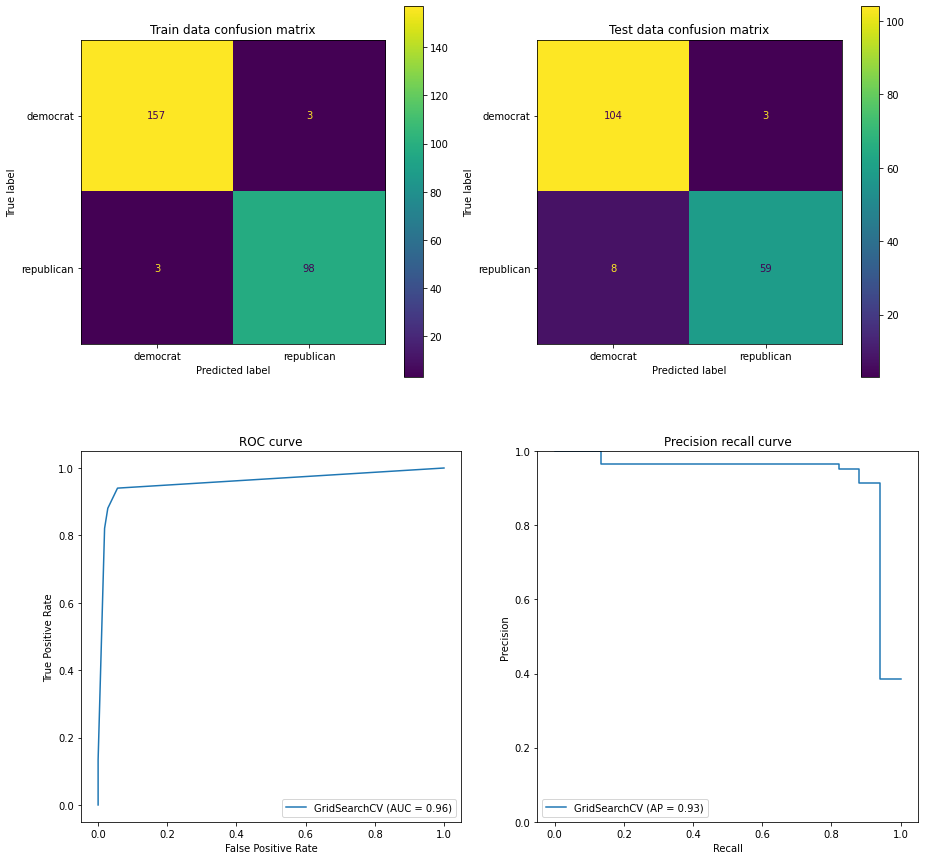

In [ ]:
plot_scores(alt_tree_tune, sets=(aX_train, aX_test, ay_train, ay_test))

### Porównanie

In [ ]:
print("OrdinalEncoding")
print_metrics(tree_tune.best_estimator_)

print("\nOneHotEncoding")
print_metrics(alt_tree_tune.best_estimator_, sets=(aX_train, aX_test, ay_train, ay_test))

OrdinalEncoding
Accuracy score (train): 0.977
Accuracy score (test): 0.937
F1 score (train): 0.977
F1 score (test): 0.937
ROC AUC score (train): 0.994
ROC AUC score (test): 0.973
Tree depth: 3
Leaf count: 7

OneHotEncoding
Accuracy score (train): 0.977
Accuracy score (test): 0.937
F1 score (train): 0.977
F1 score (test): 0.937
ROC AUC score (train): 0.994
ROC AUC score (test): 0.958
Tree depth: 3
Leaf count: 7


Wyniki bardzo podobne jak w przypadku Ordinal Encoding, więc chyba dużo nie pomogliśmy modelowi korzystając z zależności `n < ? < y`. Za to czas trenowania był mniejszy, około 1 minuta dla OrdinalEncoding, około 15s dla OneHotEncoding. Zauważyliśmy jednak tą zależność dosyć późno, przez co pozostaliśmy przy początkowym OrdinalEncoding.

## Las Losowe, kolejne podejście
Już w poprzednim podejściu zajeliśmy się kwestią lasu losowego, jednakże nie uwzględniliśmy kilku faktorów, m.in. gdyż ówczas nie dysponowaliśmy wystarczającą wiedzą z danego zakresu. Zatem, przy tym podejściu uwzględniona została kroswalidacja oraz strojenie hiperparametrów. Pomogliśmy sobie również używając nowych narzędzi do wizualizacji wyników.

In [ ]:
#n wybierane jest arbitralnie, ale 10 wydaje się opymalną liczbą
kf10 = KFold(n_splits = 10)

Powyżej skorzystaliśmy z kroswalidacji KFold oraz z GridSearchCV przy strojeniu hiperparametrów.

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1,n_estimators=50)

Optimal_forest = GridSearchCV(estimator= rfc ,param_grid={
    'n_estimators' : [5,50,100],
    'criterion' : ['gini','entropy'],
    'max_depth' : [1,2,6,10],
    'min_samples_split' : [2,4,6]
  }, 
  cv = kf10,
  return_train_score = False
)

In [ ]:
Optimal_forest.fit(X_train,y_train) 

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=-1,
                                              oob_sco

Accuracy score (train): 0.969
Accuracy score (test): 0.948
F1 score (train): 0.969
F1 score (test): 0.948
ROC AUC score (train): 0.997
ROC AUC score (test): 0.993


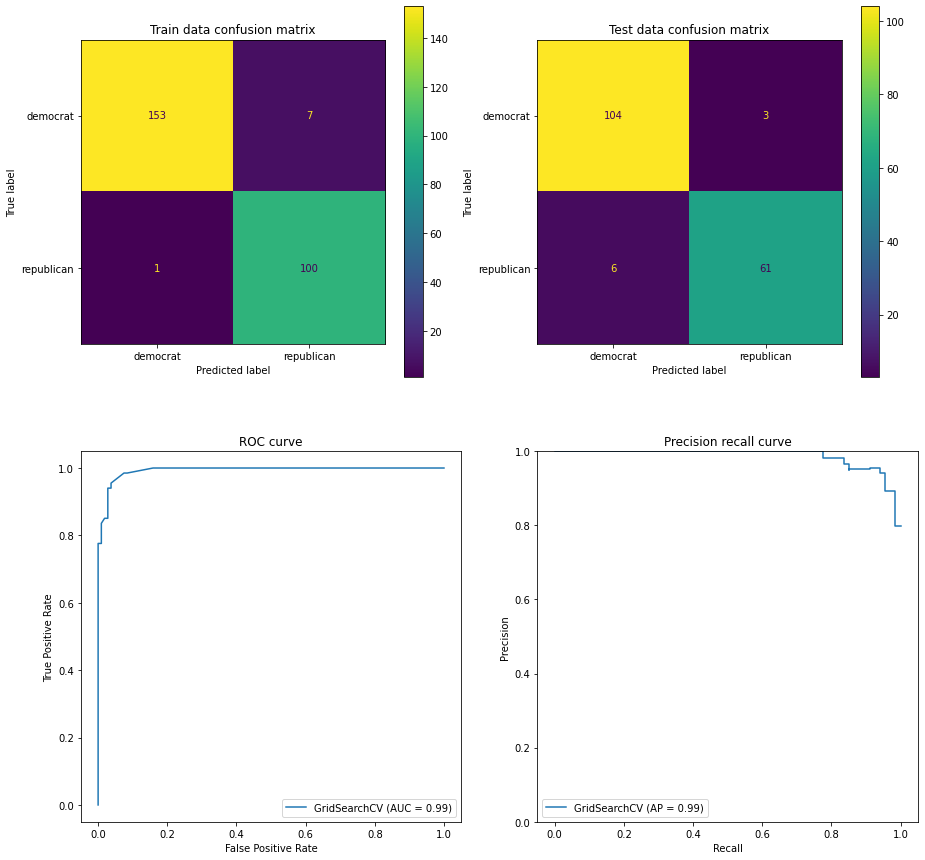

In [ ]:
print_metrics(Optimal_forest,(X_train, X_test, y_train, y_test))
plot_scores(Optimal_forest)

Poniżej wylistowaliśmy 5 najlepszych modeli wraz z ich parametrami oraz 5 najgroszych modeli wraz z ich parametrami w postaci ramek danych. Jest to idealna podstawa do przanalizowania, zorientowania się a propos grup parametrów zwracających najlepsze oraz najgorsze wynkiki. Na przykład, jak możemy zobaczyć poniżej 5 najgorszych modeli posiadało parametr "max_depth" o wartości 1, podczas gdy żaden z najlepszych nie zawierał takiej wartości.

In [ ]:
results_tuned(Optimal_forest,head=True)

,param_n_estimators,param_criterion,param_max_depth,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
57,5,entropy,6,4,0.977208,0.034823,1
22,50,gini,6,4,0.973219,0.029988,2
23,100,gini,6,4,0.973219,0.029988,2
26,100,gini,6,6,0.973219,0.029988,2
28,50,gini,10,2,0.973219,0.029988,2


In [ ]:
results_tuned(Optimal_forest,head=False)

,param_n_estimators,param_criterion,param_max_depth,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
38,100,entropy,1,2,0.904274,0.025512,68
4,50,gini,1,4,0.904131,0.035624,69
2,100,gini,1,2,0.904131,0.031197,69
7,50,gini,1,6,0.900427,0.035087,71
43,50,entropy,1,6,0.896581,0.017391,72


Poniżej znajdują się wagi dla podanych cech naszego obiektu, wedle najlepszego estymatora z RandomForest.

In [ ]:
data = {'features':df.columns[0:16], 'weights' :Optimal_forest.best_estimator_.feature_importances_ }
weights = pd.DataFrame(data)
weights = weights.sort_values(by = 'weights',ascending=  False)
weights

,features,weights
3,physician_fee_freeze,0.362631
11,education_spending,0.212117
7,aid_to_nicaraguan_contras,0.088122
2,adoption_of_the_budget_resolution,0.083547
8,mx_missile,0.079093
14,duty_free_exports,0.047594
10,synfuels_corporation_cutback,0.040920
0,handicapped_infants,0.029535
13,crime,0.014632
9,immigration,0.012619


## Naiwny Bayes, kolejne podejście
Tak samo jak w przypadku innych modeli, spróbujmy wyszukać najoptymalniejsze warunki dla algorytmu Bayesa. Tak samo jak w poprzednich podejściach ukarzemy jak i najoptymalniejsze jak i najmniej optymalne modele oraz przyjrzymy im się troche.

In [ ]:
nb = GaussianNB()

Optimal_Bayes = GridSearchCV(estimator= nb ,param_grid={
    'var_smoothing' : [pow(10,-7),pow(10,-8),pow(10,-9),pow(10,-10),pow(10,-11),pow(10,-12)],
    'priors' : [[1/2,1/2],[1/3,2/3],[0.61,0.39],[0.80,0.20],[0.1,0.9],[0.9999,0.0001],None]
  }, 
  cv = kf10,
  return_train_score = False
)

W przypadku algorytmu Bayesa nie posiadamy tak wielu atrybutów do tuningowania, jednakże najbardziej interesującym jest parametr 'priors', który a priori ustanawia prawdopodobieństwo występowania poszczególnych klas. Normalnie algorytm sam zajmuje się tą sprawą, lecz, w ramach inżynierskich testów, sprawdźmy inne jego wartości.

In [ ]:
Optimal_Bayes.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None,
             param_grid={'priors': [[0.5, 0.5],
                                    [0.3333333333333333, 0.6666666666666666],
                                    [0.61, 0.39], [0.8, 0.2], [0.1, 0.9],
                                    [0.9999, 0.0001], None],
                         'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-10, 1e-11,
                                           1e-12]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

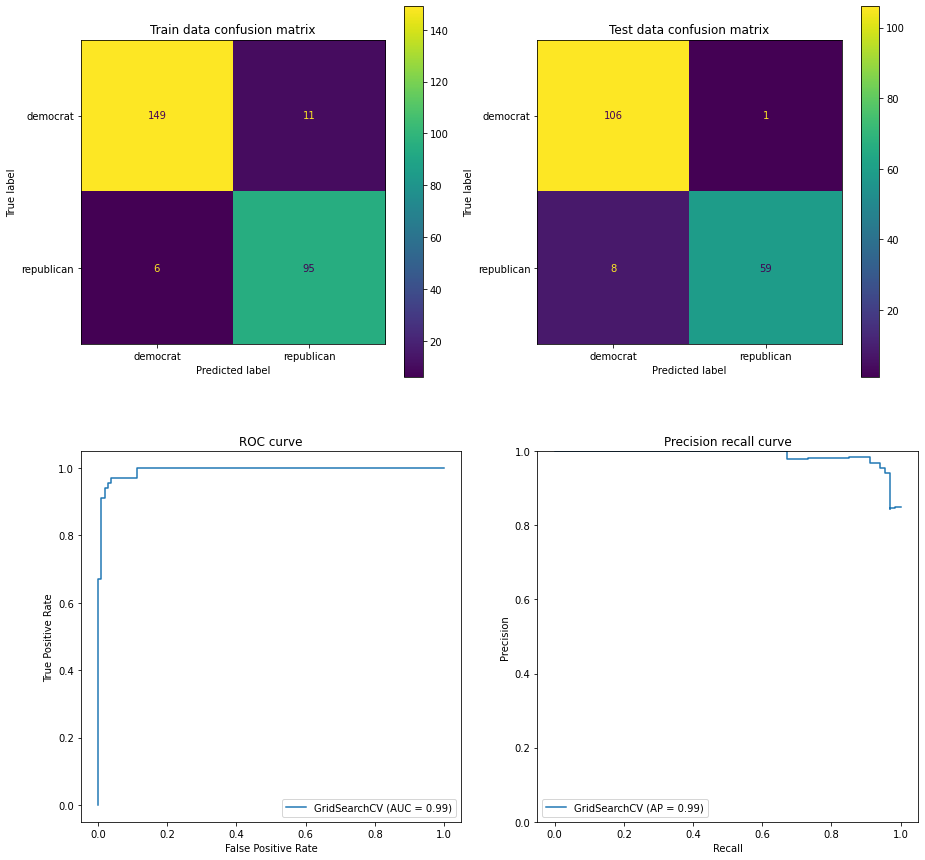

In [ ]:
plot_scores(Optimal_Bayes,(X_train, X_test, y_train, y_test))

In [ ]:
print_metrics(Optimal_Bayes,(X_train, X_test, y_train, y_test))
results_tuned(Optimal_Bayes,head = True)

Accuracy score (train): 0.935
Accuracy score (test): 0.948
F1 score (train): 0.935
F1 score (test): 0.948
ROC AUC score (train): 0.982
ROC AUC score (test): 0.993


,param_var_smoothing,param_priors,mean_test_score,std_test_score,rank_test_score
24,1e-07,"[0.1, 0.9]",0.934758,0.03017,1
26,1e-09,"[0.1, 0.9]",0.934758,0.03017,1
27,1e-10,"[0.1, 0.9]",0.934758,0.03017,1
28,1e-11,"[0.1, 0.9]",0.934758,0.03017,1
29,1e-12,"[0.1, 0.9]",0.934758,0.03017,1


In [ ]:
results_tuned(Optimal_Bayes,head = False)

,param_var_smoothing,param_priors,mean_test_score,std_test_score,rank_test_score
30,1e-07,"[0.9999, 0.0001]",0.919516,0.043717,38
33,1e-10,"[0.9999, 0.0001]",0.919516,0.043717,38
34,1e-11,"[0.9999, 0.0001]",0.919516,0.043717,38
31,1e-08,"[0.9999, 0.0001]",0.919516,0.043717,38
32,1e-09,"[0.9999, 0.0001]",0.919516,0.043717,38


Dość niezwykłą obserwacją jest najlepszy wynik uzyskany dla modelu uwzględniający wysokie pradwopodobieńsktwo dla klasy republikanina, oraz (dopełniająco) bardzo niskie dla klasy demokraty. "Na logikę" wydawać by się mogło, iż rzeczywiste oddanie proporcji powinno zwrócić naljepszy model, lecz, jak się okazało, przewaga liczebna jednej partii nieliniowo oddaje prawdopodobieństwo.

## Głębsza analiza importance
Poniżej zajmiemy się analizą feature importance wykorzystując narzędzie SHAP. Oferuje nam ono znacznie głębszą możliwość analitycznego spojrzenia na podane cechy niż prosta tabela.  

In [ ]:
!pip install shap

In [ ]:
import shap
shap.initjs()

of_proba = lambda x: Optimal_forest.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))
explainer = shap.Explainer(of_proba, med)
shap_values = explainer(X_test.astype("int"))


#model = xgboost.XGBRegressor().fit(X_train, y_train)


#explainer = shap.Explainer(model)
#shap_values = explainer(X_test)

#shap.plots.waterfall(shap_values[0])

Permutation explainer: 175it [05:24,  1.85s/it]


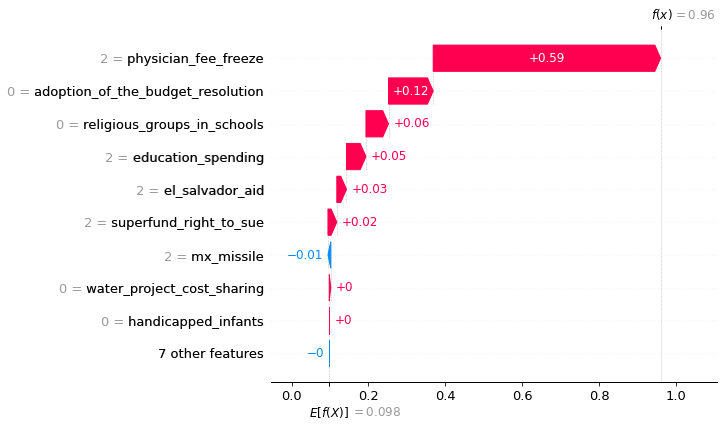

In [ ]:
shap.plots.waterfall(shap_values[10])

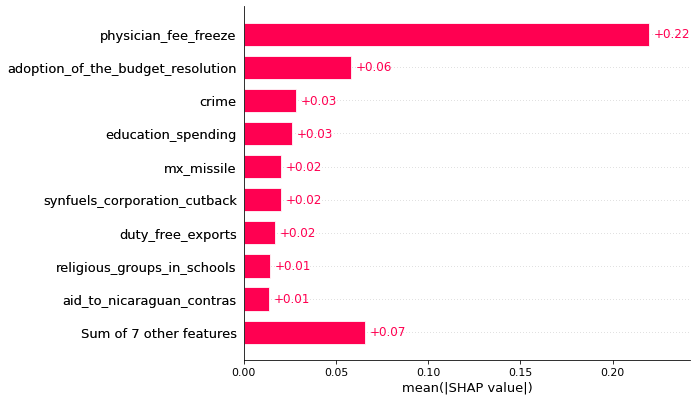

In [ ]:
shap.plots.bar(shap_values)

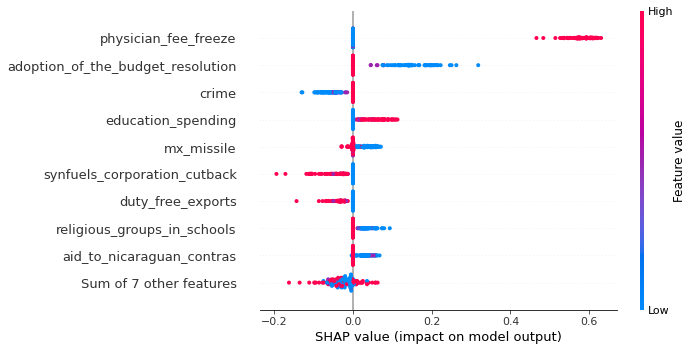

In [ ]:
shap.plots.beeswarm(shap_values)

# Odstające wartości

In [ ]:
outliers = df[y != tree_tune.predict(X)].copy()
outliers.iloc[:, -1] = party_encoder.inverse_transform(outliers.iloc[:, -1].tolist())
outliers.iloc[:, :-1] = vote_encoder.inverse_transform(outliers.iloc[:, :-1])
outliers.iloc[:, -8:]

,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa,political_party
6,n,n,n,?,y,y,y,democrat
107,?,?,?,?,y,?,?,republican
120,y,n,y,y,y,?,y,republican
197,y,n,n,n,y,n,y,republican
242,n,n,?,n,y,y,y,republican
248,?,?,?,?,?,?,?,republican
267,y,n,n,n,y,n,y,republican
296,y,n,y,y,y,y,y,republican
313,y,n,y,y,y,n,y,republican
326,n,y,n,n,y,n,y,democrat


In [ ]:
miss = df[y != tree_tune.predict(X)]
miss_d = miss[miss.political_party == 0].head(1)
miss_d = miss_d.append(miss[miss.political_party == 1].head(1))

hit = df[y == tree_tune.predict(X)]
hit_d = hit[hit.political_party == 0].head(1)
hit_d = hit_d.append(hit[hit.political_party == 1].head(1))

outliers = miss_d.append(hit_d)
outliers_X = outliers.iloc[:, :-1]

outliers.iloc[:, -1] = party_encoder.inverse_transform(outliers.iloc[:, -1].tolist())
outliers.iloc[:, :-1] = vote_encoder.inverse_transform(outliers.iloc[:, :-1])
outliers.iloc[:, -8:]

,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa,political_party
6,n,n,n,?,y,y,y,democrat
107,?,?,?,?,y,?,?,republican
2,n,y,n,y,y,n,n,democrat
0,y,?,y,y,y,n,y,republican


Jeden z polityków ma bardzo dużo wstrzymań - nasz model nie może przewidzieć co się dzieje.

In [ ]:
tt_proba = lambda x: tree_tune.predict_proba(x)[:,1]
med2 = outliers_X.median().values.reshape((1,outliers_X.shape[1]))

explainer2 = shap.Explainer(tt_proba, med2)
shap_values2 = explainer(outliers_X.astype("int"))

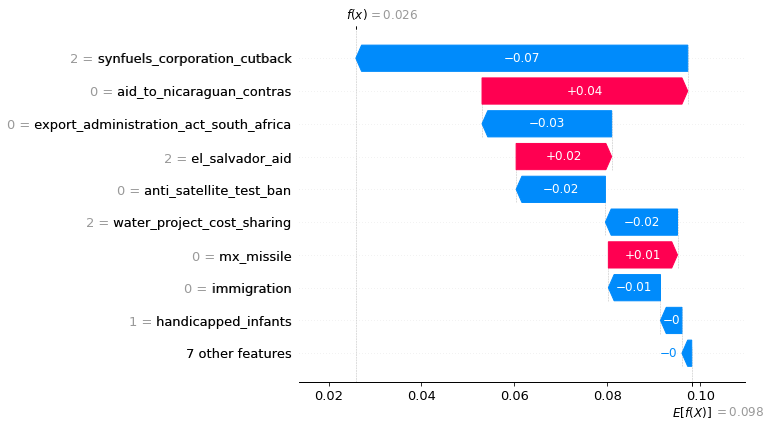

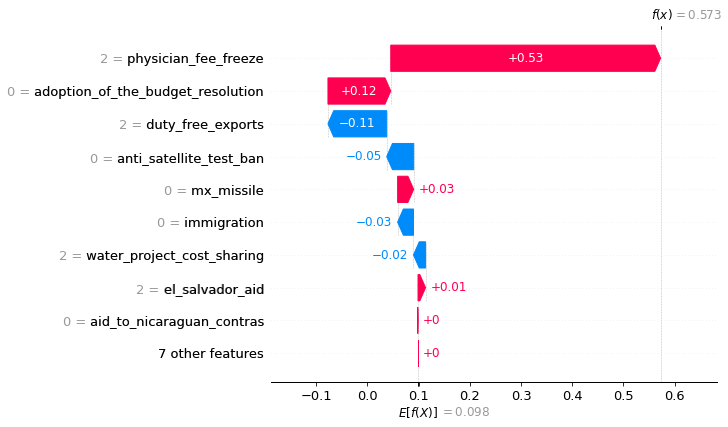

In [ ]:
shap.plots.waterfall(shap_values2[2])
shap.plots.waterfall(shap_values2[0])

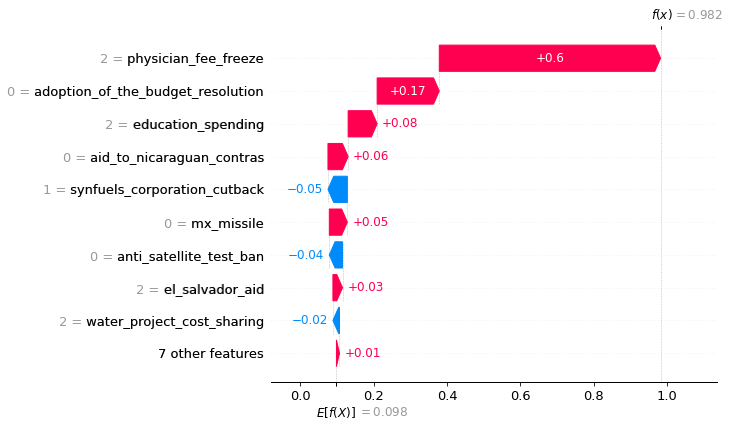

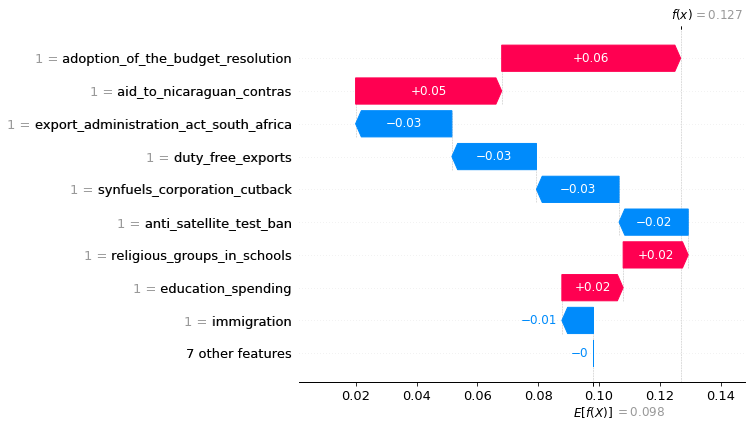

In [ ]:
shap.plots.waterfall(shap_values2[3])
shap.plots.waterfall(shap_values2[1])

Typowy Republikanin vs źle klasyfikowany.

## Zakończenie i wnioski
Po długiej drodze przebytej przez analize naszego zbioru danych oraz modeli, ostatecznie zbliżyliśmy się do jednych z najlepszych modeli jakie mogliśmy utworzyć.  
W przypadku drzew, okazało się, iż nasza intuicja była bardzo zbliżona do modelu, który otrzymaliśmy po tuningu parametrów, to samo stało się w przypadku lasu losowego.  W kwestii Naiwnego Bayesa, jak już wspomnieliśmy uprzednio zaistniała największa "niespodzianka" w kwestii parametrów.
Reasumująć struktury drzewiaste okazały się być najefektywniejsze w celach klasyfikacji w naszej ramce danych. Początkowo przy mniej rozbudowanych modelach, nasze accuracy osylowało w okolicach 90%, po głębszej analizie oraz mase łatek, ta wartość wzrosła do wartości w granicach 96%.  
Ten punkt jest oficialnym zakończeniem naszego projektu, przez te uprzednie tygodnie pracy nad nim, zapoznaliśmy się i udoskonaliśmy nasze umiejętności teoretyczne, ale przede wszystkim, praktyczne związane z machine learningiem, z problemem klasyfikacji. Niechaj będzie to zwieńczenie naszej ciężkiej pracy!